In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde, mode
from modules.training.ts_modeling import build_dataset, generate_feature_names
from modules.training.DenseReweights import exDenseReweights

C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\pydantic\_internal\_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\pydantic\_internal\_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [2]:
# SEEDING
SEED = 42  # seed number 
# Set NumPy seed
np.random.seed(SEED)
# Set TensorFlow seed
tf.random.set_seed(SEED)
# Set random seed
random.seed(SEED)

In [3]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
ouptuts_to_use = ['delta_p']
add_slope = False
# set the root directory
root_dir = '../data/electron_cme_data_split/'
subpaths = ['training', 'subtraining', 'testing', 'validation']
dataset = {
    'training': None,
    'subtraining': None,
    'testing': None,
    'validation': None
}
# build the dataset
for subpath in subpaths:
    X, y = build_dataset(
        root_dir + subpath,
        inputs_to_use=inputs_to_use,
        add_slope=add_slope,
        outputs_to_use=ouptuts_to_use)
    dataset[subpath] = (X, y)

# print all data shapes
for subpath in subpaths:
    X, y = dataset[subpath]
    print(f'{subpath} - X.shape: {X.shape}, y.shape: {y.shape}')

training - X.shape: (21656, 75, 1), y.shape: (21656, 1)
subtraining - X.shape: (17197, 75, 1), y.shape: (17197, 1)
testing - X.shape: (8810, 75, 1), y.shape: (8810, 1)
validation - X.shape: (4459, 75, 1), y.shape: (4459, 1)


In [4]:

X_train, y_train = dataset['training']
X_subtrain, y_subtrain = dataset['subtraining']
X_test, y_test = dataset['testing']
X_val, y_val = dataset['validation']

In [22]:
bw = 0.099

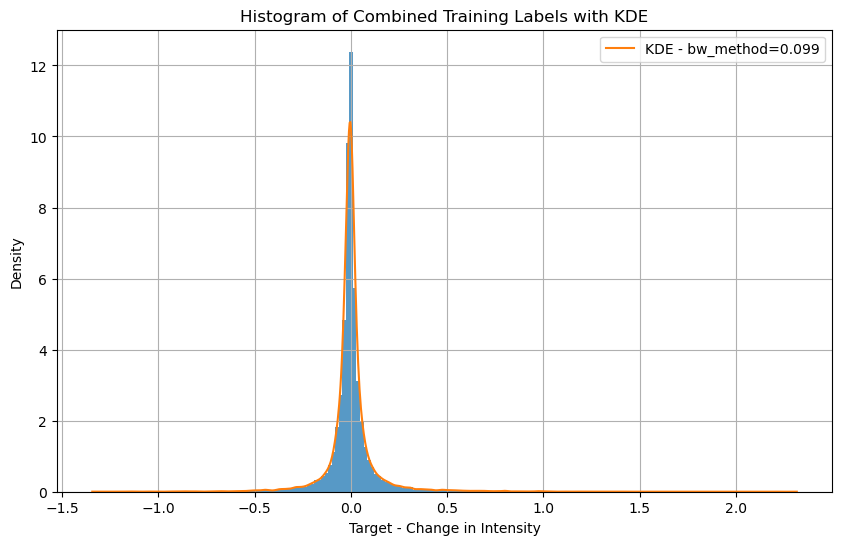

In [23]:
# Create a KDE object using the Scott method for bandwidth selection
kde = gaussian_kde(y_train.flatten(), bw_method=bw)

# Create a range of values for which we want the KDE evaluated
x_eval = np.linspace(np.min(y_train), np.max(y_train), 1000)  # Adjust range and number of points as needed

# Evaluate the KDE for each x value
density = kde.evaluate(x_eval)

# Plot the original histogram
plt.figure(figsize=(10, 6))
plt.hist(y_train.flatten(), bins=200, alpha=0.75, density=True)  # 'density=True' to normalize the histogram
plt.plot(x_eval, density, label=f'KDE - bw_method={bw}')
plt.title('Histogram of Combined Training Labels with KDE')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

In [24]:
# Step 1: Compute the KDE
data = y_train.flatten()  # Your dataset
# Step 2: Find the most frequent value
# Approach 1: Using the mode (most frequent value in the dataset)
mode_value = mode(data, keepdims=True)[0][
    0]  # 'mode' returns mode and count; we take the first mode in case of multiple modes

# Approach 2: Find the peak of the KDE (for a more continuous approximation of "most frequent")
x_eval = np.linspace(np.min(data), np.max(data), 1000)  # Range of values to evaluate
densities = kde.evaluate(x_eval)  # Evaluate the KDE
peak_index = np.argmax(densities)  # Index of the peak density
most_frequent_value = x_eval[peak_index]  # The value corresponding to the peak density

# Step 3: Evaluate the KDE at min, max, and most frequent value
min_density = kde.evaluate([np.min(data)])[0]
max_density = kde.evaluate([np.max(data)])[0]
most_frequent_density = kde.evaluate([most_frequent_value])[0]

# Step 4: Calculate the density ratios
ratio_max_to_most_frequent = max_density / most_frequent_density
ratio_min_to_most_frequent = min_density / most_frequent_density

print("Density ratio (max to most frequent):", ratio_max_to_most_frequent)
print("Density ratio (min to most frequent):", ratio_min_to_most_frequent)

Density ratio (max to most frequent): 0.0001224363496543439
Density ratio (min to most frequent): 0.00022266633647418245


In [25]:
# Compute the sample weights
delta_train = y_train[:, 0]
min_norm_weight = 0.01 / len(delta_train)
combined_sample_weights = exDenseReweights(
    X_train, delta_train, alpha=1, bw=bw, min_norm_weight=min_norm_weight, debug=False).reweights

# Find min and max y values
min_y_value = np.min(delta_train)
max_y_value = np.max(delta_train)
# find index of min and max values 
min_y_index = np.argmin(delta_train)
print(f'weight of minimum {min_y_value}: {combined_sample_weights[min_y_index]}')
max_y_index = np.argmax(delta_train)
print(f'weight of maximum {max_y_value}: {combined_sample_weights[max_y_index]}')

weight of minimum -1.3432244844152144: 0.54034203278304
weight of maximum 2.3157651077870685: 5405.131295045574


In [59]:
import numpy as np
from scipy.stats import mode
from scipy.stats import gaussian_kde

# Assuming y_train is your dataset
data = y_train.flatten()

# Mode approach
mode_value = mode(data, keepdims=True)[0][0]  # Simplified mode extraction

# KDE approach
kde = gaussian_kde(data, bw_method=bw)  # Assuming your KDE is initialized here
x_eval = np.linspace(np.min(data), np.max(data), 1000)
densities = kde.evaluate(x_eval)
peak_index = np.argmax(densities)
most_frequent_value = x_eval[peak_index]


In [26]:
min_density = kde.evaluate([np.min(data)])[0]
max_density = kde.evaluate([np.max(data)])[0]
most_frequent_density = kde.evaluate([most_frequent_value])[0]

ratio_max_to_most_frequent = most_frequent_density / max_density
ratio_min_to_most_frequent =  most_frequent_density / min_density

print("Density ratio (max to most frequent):", ratio_max_to_most_frequent)
print("Density ratio (min to most frequent):", ratio_min_to_most_frequent)


Density ratio (max to most frequent): 8167.5091002234985
Density ratio (min to most frequent): 4491.02462381397


In [61]:
# Assuming exDenseReweights is correctly defined elsewhere and bw is defined
combined_sample_weights = exDenseReweights(X_train, delta_train, alpha=1, bw=bw, min_norm_weight=None, debug=False).reweights


In [27]:
# Find weights for min, max, and most frequent (mode)
min_weight = combined_sample_weights[min_y_index]
max_weight = combined_sample_weights[max_y_index]
# Assuming mode_value is close enough to an actual value in delta_train to find its weight
mode_index = (np.abs(delta_train - mode_value)).argmin()
mode_weight = combined_sample_weights[mode_index]

# Compute the reweighting ratios
reweight_ratio_max_to_mode = max_weight / mode_weight
reweight_ratio_min_to_mode = min_weight / mode_weight

print(f"Reweight ratio (max to mode): {reweight_ratio_max_to_mode}")
print(f"Reweight ratio (min to mode): {reweight_ratio_min_to_mode}")


Reweight ratio (max to mode): 98416373.60934375
Reweight ratio (min to mode): 9838.522039964537


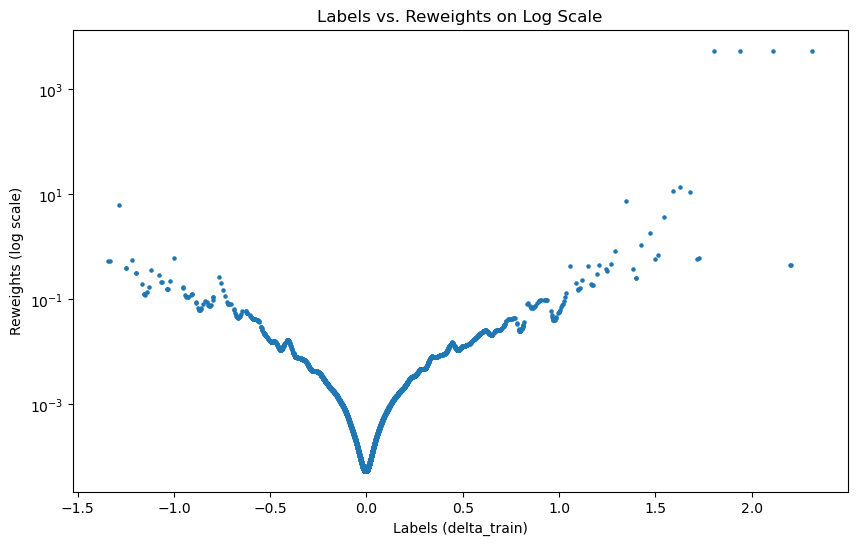

In [28]:
plt.figure(figsize=(10, 6))

# Scatter plot of labels vs. reweights
plt.scatter(delta_train, combined_sample_weights, alpha=1, s=5)

# Setting the y-axis to log scale to better visualize the weights
plt.yscale('log')

# Labeling the axes
plt.xlabel('Labels (delta_train)')
plt.ylabel('Reweights (log scale)')

# Adding a title to the plot
plt.title('Labels vs. Reweights on Log Scale')

# Display the plot
plt.show()

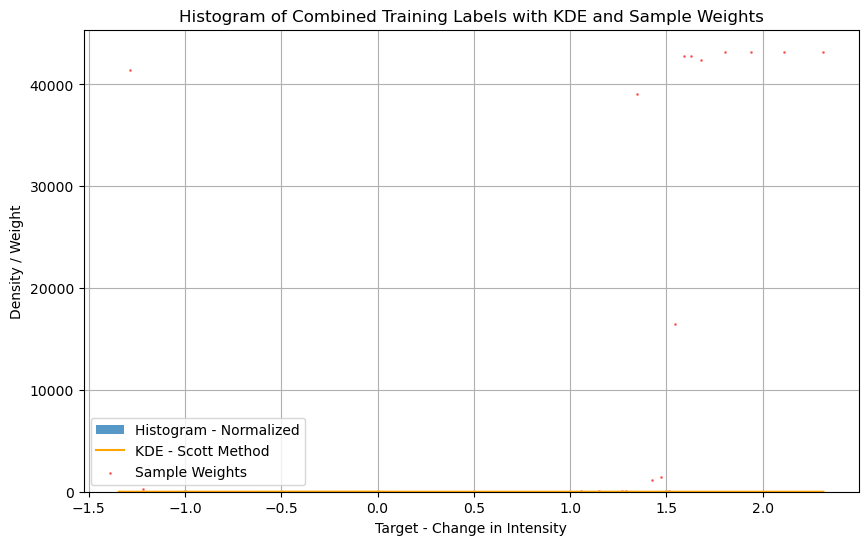

In [9]:
# Assuming 'y_train' is your dataset and 'combined_sample_weights' are the weights you mentioned

# Create a KDE object using the Scott method for bandwidth selection
kde = gaussian_kde(y_train, bw_method=bw)

# Create a range of values for which we want the KDE evaluated
x_eval = np.linspace(np.min(y_train), np.max(y_train), 1000)  # Adjust range and number of points as needed

# Evaluate the KDE for each x value
density = kde.evaluate(x_eval)

# Plot the original histogram and KDE
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=200, alpha=0.75, density=True,
         label='Histogram - Normalized')  # 'density=True' to normalize the histogram
plt.plot(x_eval, density, label='KDE - Scott Method', color='orange')

# Since 'combined_sample_weights' and 'y_train' should align, we plot the weights against the y_train values
# It's important to normalize or scale the weights if they're on a very different scale from your KDE/density values
# This step might require adjusting the 's' parameter (size) based on your data scale
plt.scatter(y_train, combined_sample_weights * np.max(density), label='Sample Weights', color='red', s=1, alpha=0.5)

plt.title('Histogram of Combined Training Labels with KDE and Sample Weights')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Density / Weight')
plt.grid(True)
plt.legend()
plt.show()

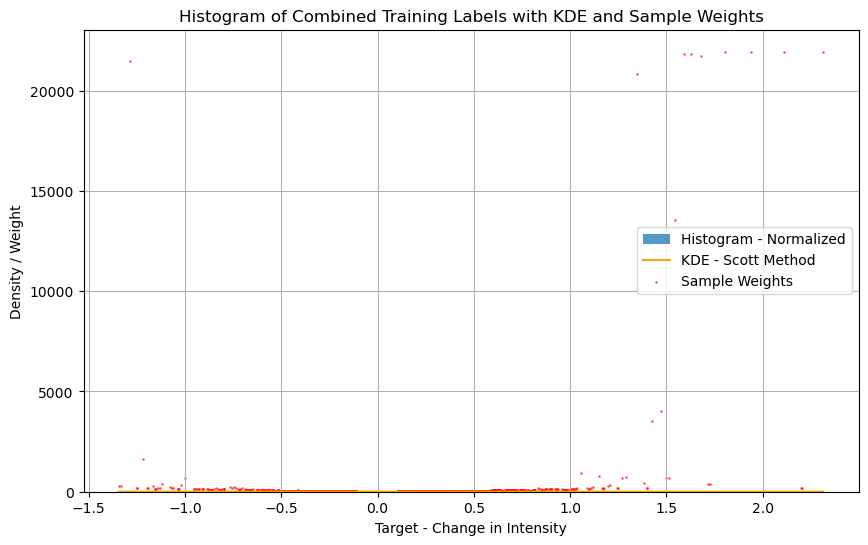

In [10]:
min_norm_weight = 0.01 / len(y_train)
combined_sample_weights = exDenseReweights(
    X_train, y_train, alpha=0.5, bw=bw, min_norm_weight=min_norm_weight, debug=False).reweights

# Assuming 'y_train' is your dataset and 'combined_sample_weights' are the weights you mentioned

# Create a KDE object using the Scott method for bandwidth selection
kde = gaussian_kde(y_train, bw_method=bw)

# Create a range of values for which we want the KDE evaluated
x_eval = np.linspace(np.min(y_train), np.max(y_train), 1000)  # Adjust range and number of points as needed

# Evaluate the KDE for each x value
density = kde.evaluate(x_eval)

# Plot the original histogram and KDE
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=200, alpha=0.75, density=True,
         label='Histogram - Normalized')  # 'density=True' to normalize the histogram
plt.plot(x_eval, density, label='KDE - Scott Method', color='orange')

# Since 'combined_sample_weights' and 'y_train' should align, we plot the weights against the y_train values
# It's important to normalize or scale the weights if they're on a very different scale from your KDE/density values
# This step might require adjusting the 's' parameter (size) based on your data scale
plt.scatter(y_train, combined_sample_weights * np.max(density), label='Sample Weights', color='red', s=1, alpha=0.5)

plt.title('Histogram of Combined Training Labels with KDE and Sample Weights')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Density / Weight')
plt.grid(True)
plt.legend()
plt.show()

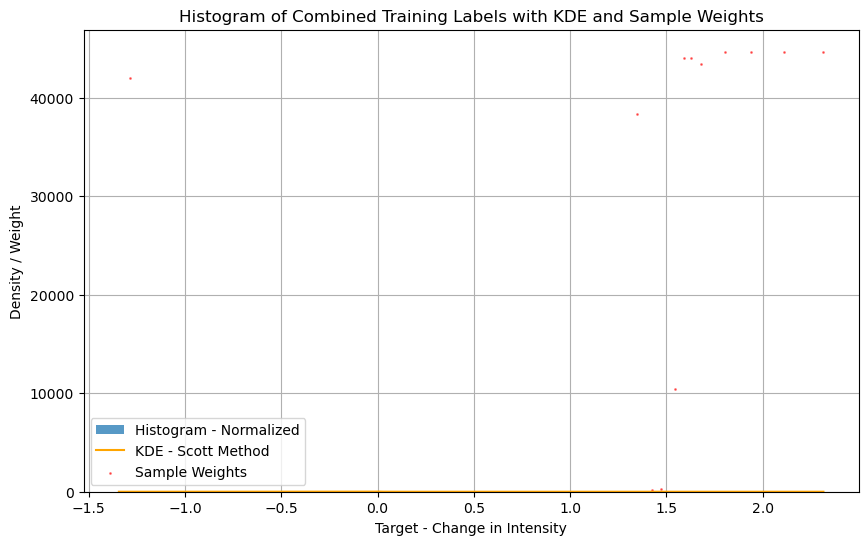

In [11]:
min_norm_weight = 0.01 / len(y_train)
combined_sample_weights = exDenseReweights(
    X_train, y_train, alpha=1.5, bw=bw, min_norm_weight=min_norm_weight, debug=False).reweights

# Assuming 'y_train' is your dataset and 'combined_sample_weights' are the weights you mentioned

# Create a KDE object using the Scott method for bandwidth selection
kde = gaussian_kde(y_train, bw_method=bw)

# Create a range of values for which we want the KDE evaluated
x_eval = np.linspace(np.min(y_train), np.max(y_train), 1000)  # Adjust range and number of points as needed

# Evaluate the KDE for each x value
density = kde.evaluate(x_eval)

# Plot the original histogram and KDE
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=200, alpha=0.75, density=True,
         label='Histogram - Normalized')  # 'density=True' to normalize the histogram
plt.plot(x_eval, density, label='KDE - Scott Method', color='orange')

# Since 'combined_sample_weights' and 'y_train' should align, we plot the weights against the y_train values
# It's important to normalize or scale the weights if they're on a very different scale from your KDE/density values
# This step might require adjusting the 's' parameter (size) based on your data scale
plt.scatter(y_train, combined_sample_weights * np.max(density), label='Sample Weights', color='red', s=1, alpha=0.5)

plt.title('Histogram of Combined Training Labels with KDE and Sample Weights')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Density / Weight')
plt.grid(True)
plt.legend()
plt.show()

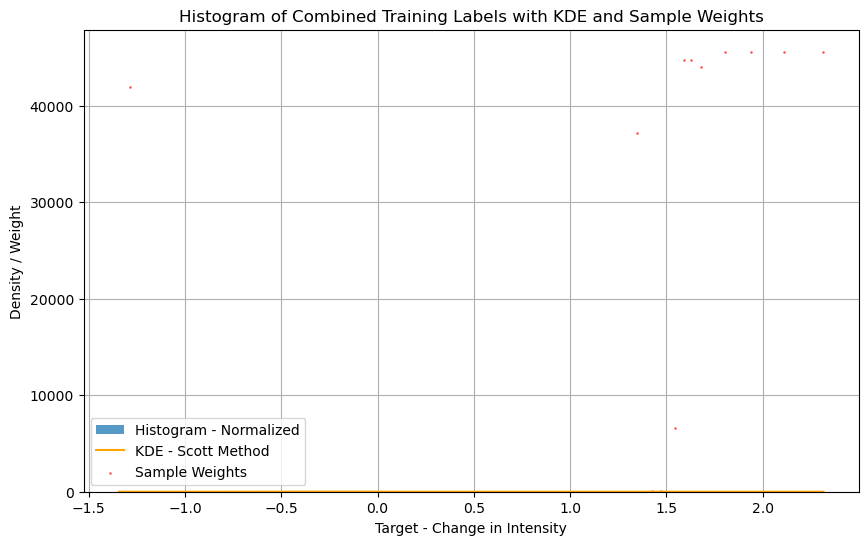

In [12]:
min_norm_weight = 0.01 / len(y_train)
combined_sample_weights = exDenseReweights(
    X_train, y_train, alpha=2, bw=bw, min_norm_weight=min_norm_weight, debug=False).reweights

# Assuming 'y_train' is your dataset and 'combined_sample_weights' are the weights you mentioned

# Create a KDE object using the Scott method for bandwidth selection
kde = gaussian_kde(y_train, bw_method=bw)

# Create a range of values for which we want the KDE evaluated
x_eval = np.linspace(np.min(y_train), np.max(y_train), 1000)  # Adjust range and number of points as needed

# Evaluate the KDE for each x value
density = kde.evaluate(x_eval)

# Plot the original histogram and KDE
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=200, alpha=0.75, density=True,
         label='Histogram - Normalized')  # 'density=True' to normalize the histogram
plt.plot(x_eval, density, label='KDE - Scott Method', color='orange')

# Since 'combined_sample_weights' and 'y_train' should align, we plot the weights against the y_train values
# It's important to normalize or scale the weights if they're on a very different scale from your KDE/density values
# This step might require adjusting the 's' parameter (size) based on your data scale
plt.scatter(y_train, combined_sample_weights * np.max(density), label='Sample Weights', color='red', s=1, alpha=0.5)

plt.title('Histogram of Combined Training Labels with KDE and Sample Weights')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Density / Weight')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
from modules.training.DenseReweights import DenseJointReweights

In [ ]:
min_norm_weight = 0.01 / len(y_train)

train_jweights = DenseJointReweights(X_train, y_train,
                                     alpha=.9, bw='scott',
                                     min_norm_weight=min_norm_weight,
                                     debug=True)

In [ ]:
# Assuming train_jweights contains the combined joint reweighting info
train_sample_joint_weights = train_jweights.jreweights
train_sample_joint_weights_indices = train_jweights.jindices


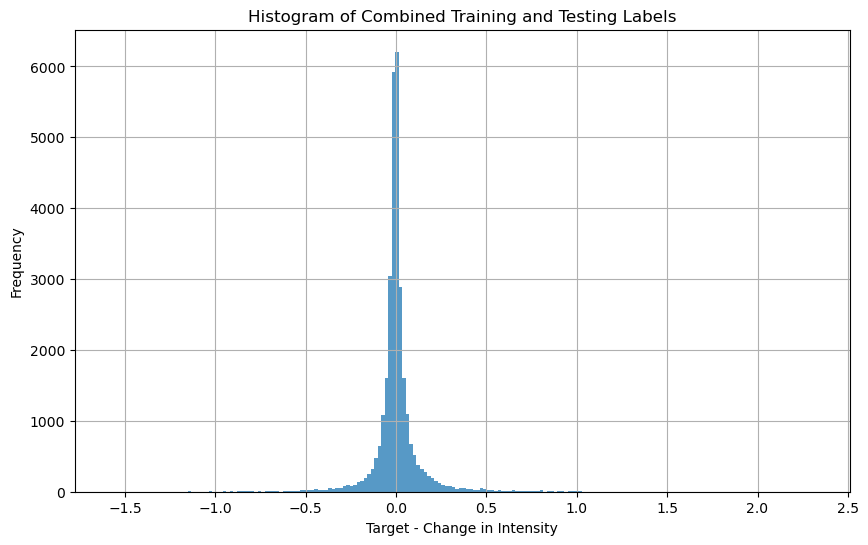

In [29]:
# Assuming y_train and y_test are your training and testing label arrays
# Combine the training and testing labels
combined_labels = np.concatenate([y_train, y_test])

# Plot the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(combined_labels, bins=200, alpha=0.75)  # Adjust 'bins' as needed
plt.title('Histogram of Combined Training and Testing Labels')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [30]:
# Find min and max y values
min_y_value = np.min(combined_labels)
max_y_value = np.max(combined_labels)
# Calculate frequencies of min and max y values
min_y_freq = np.count_nonzero(combined_labels == min_y_value)
max_y_freq = np.count_nonzero(combined_labels == max_y_value)
print(f'Min Y: {min_y_value}, Frequency: {min_y_freq}')
print(f'Max Y: {max_y_value}, Frequency: {max_y_freq}')

Min Y: -1.5838650212232528, Frequency: 1
Max Y: 2.3157651077870685, Frequency: 1


Highest frequency bin center: 0.005234256348452981, Frequency: 6208.0


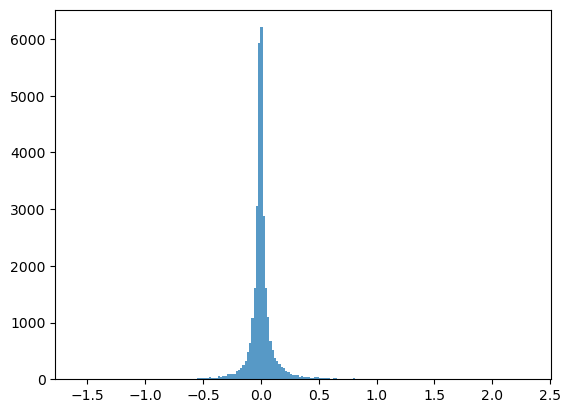

In [31]:
# Plot the histogram and get bin counts and edges
counts, bins, patches = plt.hist(combined_labels, bins=200, alpha=0.75)

# Find the bin with the highest frequency
highest_freq_index = np.argmax(counts)
highest_freq_bin_center = (bins[highest_freq_index] + bins[highest_freq_index + 1]) / 2
highest_freq = counts[highest_freq_index]
print(f'Highest frequency bin center: {highest_freq_bin_center}, Frequency: {highest_freq}')

In [ ]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
input_to_return = 'p_t'
add_slope = False
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_univariate_dataset(root_dir + '/training',
                                            inputs_to_use=inputs_to_use,
                                            input_to_return=input_to_return,
                                            add_slope=add_slope,
                                            target_change=target_change)
X_subtrain, y_subtrain = build_univariate_dataset(root_dir + '/subtraining',
                                                  inputs_to_use=inputs_to_use,
                                                  input_to_return=input_to_return,
                                                  add_slope=add_slope,
                                                  target_change=target_change)
X_test, y_test = build_univariate_dataset(root_dir + '/testing',
                                          inputs_to_use=inputs_to_use,
                                          input_to_return=input_to_return,
                                          add_slope=add_slope,
                                          target_change=target_change)
X_val, y_val = build_univariate_dataset(root_dir + '/validation',
                                        inputs_to_use=inputs_to_use,
                                        input_to_return=input_to_return,
                                        add_slope=add_slope,
                                        target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

In [ ]:
# Since X_train, and other datasets, are in the shape (n_samples, 1), we need to flatten them to (n_samples,)
X_train_flat = X_train.flatten()

# Plotting the target vs input feature 'p_t'
plt.figure(figsize=(10, 6))
plt.scatter(X_train_flat, y_train, alpha=0.5, label='Training data', s=1)
plt.title('Target vs. Input Feature (p_t)')
plt.xlabel('Input Feature (p_t)')
plt.ylabel('Target')
plt.legend()
plt.show()

In [2]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
input_to_return = 'e0.5_t'
add_slope = False
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_univariate_dataset(root_dir + '/training',
                                            inputs_to_use=inputs_to_use,
                                            input_to_return=input_to_return,
                                            add_slope=add_slope,
                                            target_change=target_change)
X_subtrain, y_subtrain = build_univariate_dataset(root_dir + '/subtraining',
                                                  inputs_to_use=inputs_to_use,
                                                  input_to_return=input_to_return,
                                                  add_slope=add_slope,
                                                  target_change=target_change)
X_test, y_test = build_univariate_dataset(root_dir + '/testing',
                                          inputs_to_use=inputs_to_use,
                                          input_to_return=input_to_return,
                                          add_slope=add_slope,
                                          target_change=target_change)
X_val, y_val = build_univariate_dataset(root_dir + '/validation',
                                        inputs_to_use=inputs_to_use,
                                        input_to_return=input_to_return,
                                        add_slope=add_slope,
                                        target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

# Since X_train, and other datasets, are in the shape (n_samples, 1), we need to flatten them to (n_samples,)
X_train_flat = X_train.flatten()

# Plotting the target vs input feature 'p_t'
plt.figure(figsize=(10, 6))
plt.scatter(X_train_flat, y_train, alpha=0.5, label='Training data', s=1, color='orange')
plt.title('Target vs. Input Feature (e0.5_t)')
plt.xlabel('Input Feature (e0.5_t)')
plt.ylabel('Target')
plt.legend()
plt.show()

NameError: name 'build_univariate_dataset' is not defined

X_train.shape: (24217, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 1)
y_val.shape: (5265,)
X_train[0]: [0.42521301]
y_train[0]: 0.7607123667223692


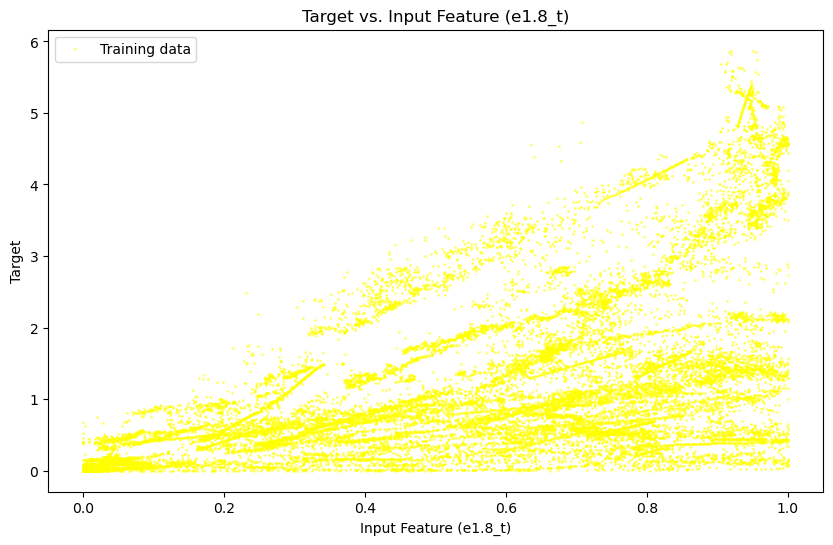

In [13]:
inputs_to_use = ['e1.8', 'e1.8', 'p']
input_to_return = 'e1.8_t'
add_slope = False
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_univariate_dataset(root_dir + '/training',
                                            inputs_to_use=inputs_to_use,
                                            input_to_return=input_to_return,
                                            add_slope=add_slope,
                                            target_change=target_change)
X_subtrain, y_subtrain = build_univariate_dataset(root_dir + '/subtraining',
                                                  inputs_to_use=inputs_to_use,
                                                  input_to_return=input_to_return,
                                                  add_slope=add_slope,
                                                  target_change=target_change)
X_test, y_test = build_univariate_dataset(root_dir + '/testing',
                                          inputs_to_use=inputs_to_use,
                                          input_to_return=input_to_return,
                                          add_slope=add_slope,
                                          target_change=target_change)
X_val, y_val = build_univariate_dataset(root_dir + '/validation',
                                        inputs_to_use=inputs_to_use,
                                        input_to_return=input_to_return,
                                        add_slope=add_slope,
                                        target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

# Since X_train, and other datasets, are in the shape (n_samples, 1), we need to flatten them to (n_samples,)
X_train_flat = X_train.flatten()

# Plotting the target vs input feature 'p_t'
plt.figure(figsize=(10, 6))
plt.scatter(X_train_flat, y_train, alpha=0.5, label='Training data', s=1, color='yellow')
plt.title('Target vs. Input Feature (e1.8_t)')
plt.xlabel('Input Feature (e1.8_t)')
plt.ylabel('Target')
plt.legend()
plt.show()

In [14]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
add_slope = False
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_dataset(root_dir + '/training',
                                 inputs_to_use=inputs_to_use,
                                 add_slope=add_slope,
                                 target_change=target_change)
X_subtrain, y_subtrain = build_dataset(root_dir + '/subtraining',
                                       inputs_to_use=inputs_to_use,
                                       add_slope=add_slope,
                                       target_change=target_change)
X_test, y_test = build_dataset(root_dir + '/testing',
                               inputs_to_use=inputs_to_use,
                               add_slope=add_slope,
                               target_change=target_change)
X_val, y_val = build_dataset(root_dir + '/validation',
                             inputs_to_use=inputs_to_use,
                             add_slope=add_slope,
                             target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

(24217, 75, 1)
(24217,)
(18952, 75, 1)
(18952,)
(10357, 75, 1)
(10357,)
(5265, 75, 1)
(5265,)
X_train.shape: (24217, 75, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 75, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 75, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 75, 1)
y_val.shape: (5265,)
X_train[0]: [[0.83291813]
 [0.83244193]
 [0.83128651]
 [0.83031191]
 [0.82795357]
 [0.82972685]
 [0.82913708]
 [0.82226368]
 [0.81980303]
 [0.81911433]
 [0.81761693]
 [0.81884725]
 [0.81879556]
 [0.81841966]
 [0.81626247]
 [0.81702354]
 [0.81599169]
 [0.81549917]
 [0.81538844]
 [0.81522678]
 [0.81357089]
 [0.81149916]
 [0.81334833]
 [0.81401486]
 [0.81195032]
 [0.48465527]
 [0.4788582 ]
 [0.4788582 ]
 [0.47614084]
 [0.47311252]
 [0.47398247]
 [0.47180709]
 [0.45771414]
 [0.44302786]
 [0.44819982]
 [0.45129612]
 [0.4395381 ]
 [0.45298753]
 [0.44381562]
 [0.44287087]
 [0.44223638]
 [0.44144699]
 [0.44001532]
 [0.43358671]
 [0.43114536]
 [0.44413254]
 [0.43163419]
 [0.43260982]
 [0.4361

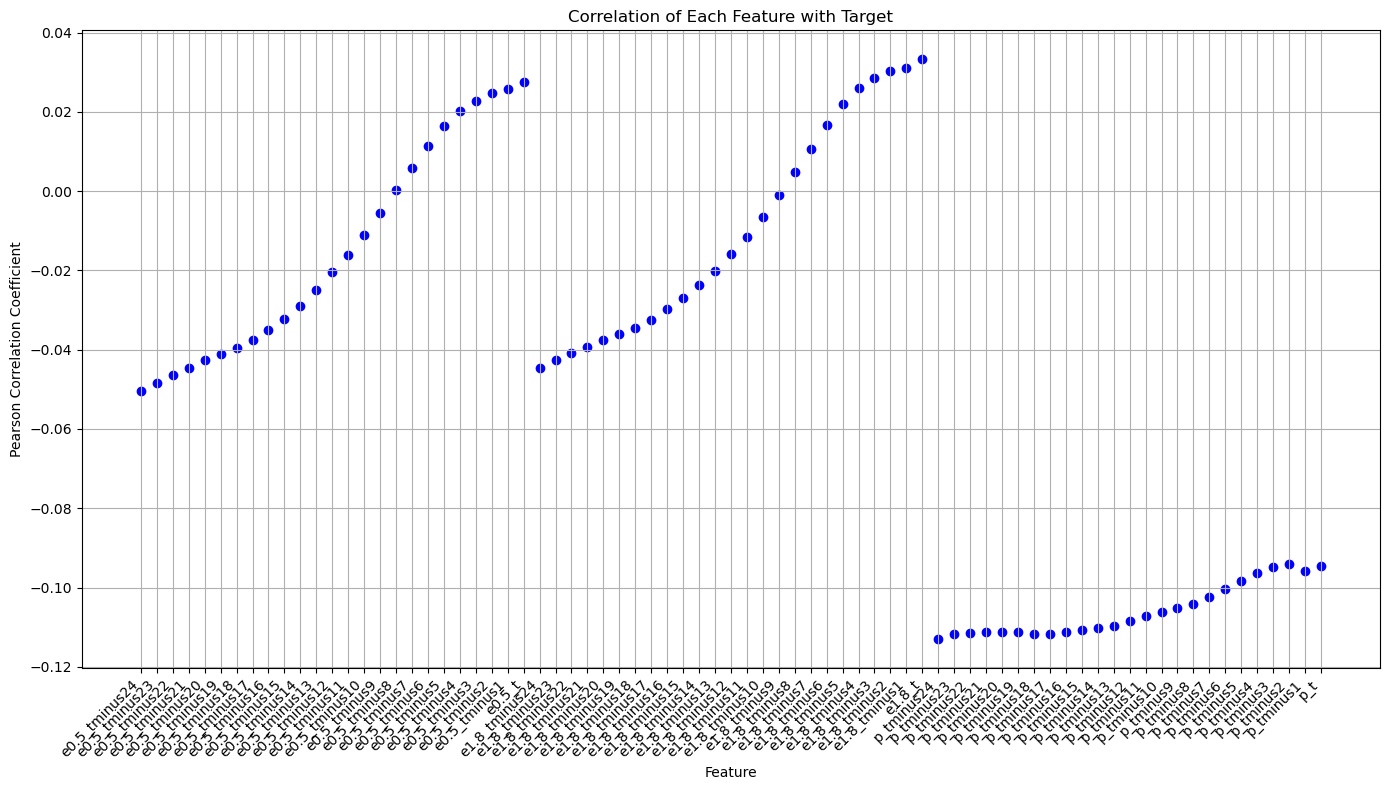

In [18]:
# Assuming X_train is shaped (24217, 75, 1) and y_train is (24217,)
# Reshape X_train to (24217, 75) for easier processing
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1])

# Initialize a list to hold correlation coefficients
correlations = []

# Calculate the Pearson correlation coefficient for each feature
for i in range(X_train_reshaped.shape[1]):
    corr, _ = pearsonr(X_train_reshaped[:, i], y_train)
    correlations.append(corr)

feature_names = generate_feature_names(inputs_to_use, add_slope)

# Plotting as a scatter plot
plt.figure(figsize=(14, 8))  # Adjusted figure size for better legibility
plt.scatter(range(len(correlations)), correlations, color='b')  # Use scatter instead of plot

# Adding feature names on the x-axis
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")  # Rotate labels to prevent overlap

plt.title('Correlation of Each Feature with Target')
plt.xlabel('Feature')
plt.ylabel('Pearson Correlation Coefficient')
plt.grid(True)

# Tight layout often solves cutting off issues
plt.tight_layout()
plt.show()

In [4]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
add_slope = True
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_dataset(root_dir + '/training',
                                 inputs_to_use=inputs_to_use,
                                 add_slope=add_slope,
                                 target_change=target_change)
X_subtrain, y_subtrain = build_dataset(root_dir + '/subtraining',
                                       inputs_to_use=inputs_to_use,
                                       add_slope=add_slope,
                                       target_change=target_change)
X_test, y_test = build_dataset(root_dir + '/testing',
                               inputs_to_use=inputs_to_use,
                               add_slope=add_slope,
                               target_change=target_change)
X_val, y_val = build_dataset(root_dir + '/validation',
                             inputs_to_use=inputs_to_use,
                             add_slope=add_slope,
                             target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
# print(f'X_train[0]: {X_train[0]}')
# print(f'y_train[0]: {y_train[0]}')

(24217, 147, 1)
(24217,)
(18952, 147, 1)
(18952,)
(10357, 147, 1)
(10357,)
(5265, 147, 1)
(5265,)
X_train.shape: (24217, 147, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 147, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 147, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 147, 1)
y_val.shape: (5265,)


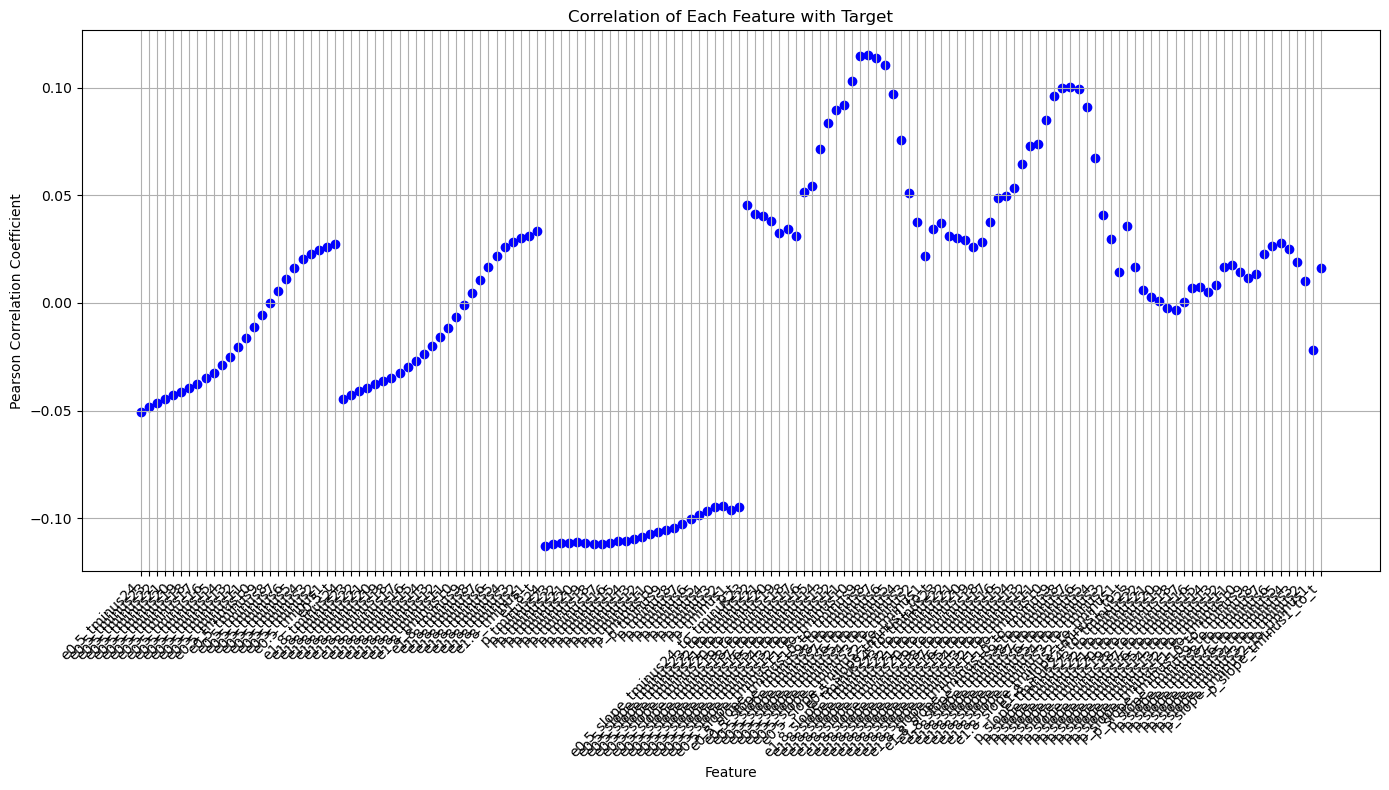

In [5]:
# Assuming X_train is shaped (24217, 75, 1) and y_train is (24217,)
# Reshape X_train to (24217, 75) for easier processing
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1])

# Initialize a list to hold correlation coefficients
correlations = []

# Calculate the Pearson correlation coefficient for each feature
for i in range(X_train_reshaped.shape[1]):
    corr, _ = pearsonr(X_train_reshaped[:, i], y_train)
    correlations.append(corr)

feature_names = generate_feature_names(inputs_to_use, add_slope)

# Plotting as a scatter plot
plt.figure(figsize=(14, 8))  # Adjusted figure size for better legibility
plt.scatter(range(len(correlations)), correlations, color='b')  # Use scatter instead of plot

# Adding feature names on the x-axis
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")  # Rotate labels to prevent overlap

plt.title('Correlation of Each Feature with Target')
plt.xlabel('Feature')
plt.ylabel('Pearson Correlation Coefficient')
plt.grid(True)

# Tight layout often solves cutting off issues
plt.tight_layout()
plt.show()

In [6]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
add_slope = True
target_change = False
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_dataset(root_dir + '/training',
                                 inputs_to_use=inputs_to_use,
                                 add_slope=add_slope,
                                 target_change=target_change)
X_subtrain, y_subtrain = build_dataset(root_dir + '/subtraining',
                                       inputs_to_use=inputs_to_use,
                                       add_slope=add_slope,
                                       target_change=target_change)
X_test, y_test = build_dataset(root_dir + '/testing',
                               inputs_to_use=inputs_to_use,
                               add_slope=add_slope,
                               target_change=target_change)
X_val, y_val = build_dataset(root_dir + '/validation',
                             inputs_to_use=inputs_to_use,
                             add_slope=add_slope,
                             target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
# print(f'X_train[0]: {X_train[0]}')
# print(f'y_train[0]: {y_train[0]}')

(24217, 147, 1)
(24217,)
(18952, 147, 1)
(18952,)
(10357, 147, 1)
(10357,)
(5265, 147, 1)
(5265,)
X_train.shape: (24217, 147, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 147, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 147, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 147, 1)
y_val.shape: (5265,)


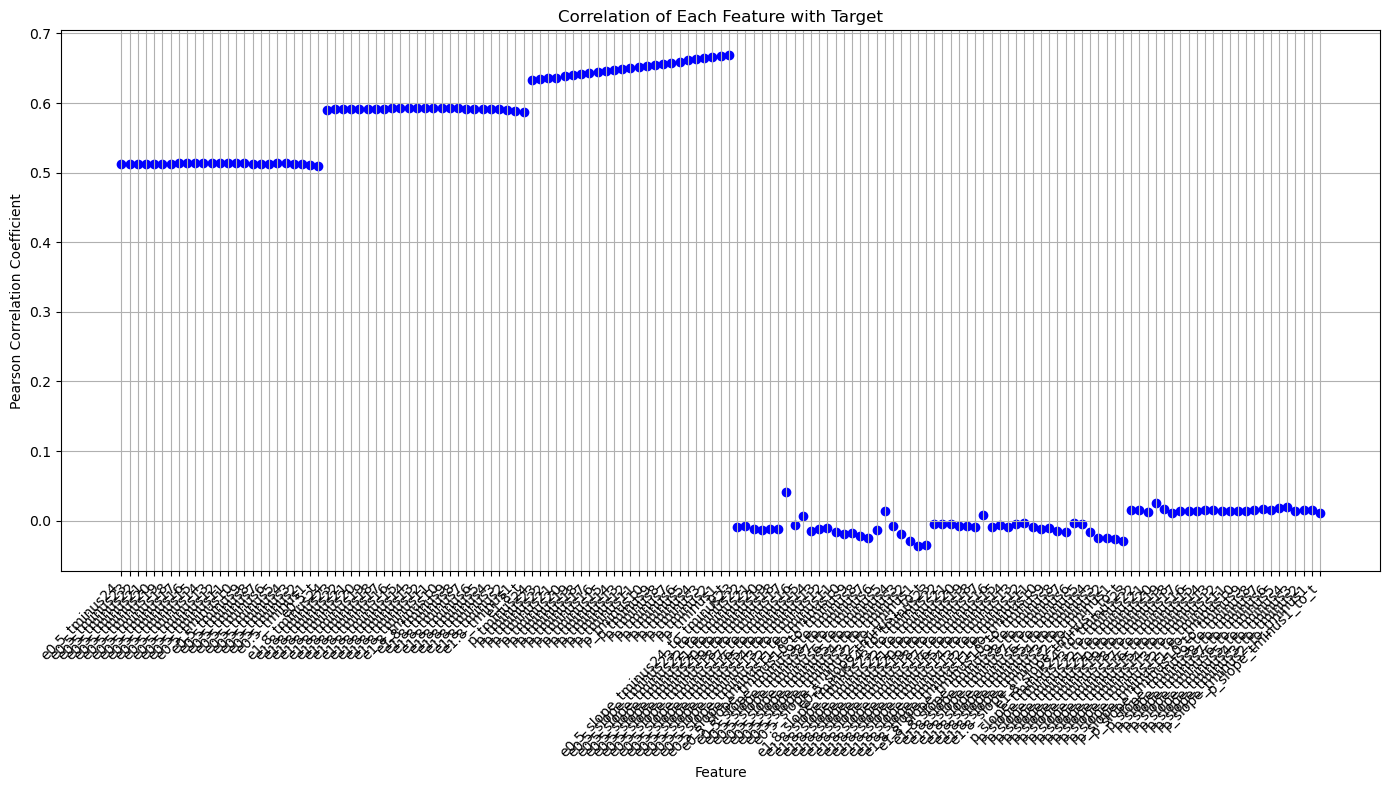

In [7]:
# Assuming X_train is shaped (24217, 75, 1) and y_train is (24217,)
# Reshape X_train to (24217, 75) for easier processing
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1])

# Initialize a list to hold correlation coefficients
correlations = []

# Calculate the Pearson correlation coefficient for each feature
for i in range(X_train_reshaped.shape[1]):
    corr, _ = pearsonr(X_train_reshaped[:, i], y_train)
    correlations.append(corr)

feature_names = generate_feature_names(inputs_to_use, add_slope)

# Plotting as a scatter plot
plt.figure(figsize=(14, 8))  # Adjusted figure size for better legibility
plt.scatter(range(len(correlations)), correlations, color='b')  # Use scatter instead of plot

# Adding feature names on the x-axis
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")  # Rotate labels to prevent overlap

plt.title('Correlation of Each Feature with Target')
plt.xlabel('Feature')
plt.ylabel('Pearson Correlation Coefficient')
plt.grid(True)

# Tight layout often solves cutting off issues
plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import time
from modules.training.cme_modeling import ModelBuilder

mb = ModelBuilder()

In [2]:
# Dummy data
batch_indices = np.random.randint(0, 100, size=1600)
joint_weights = np.random.rand(1000)
joint_weight_indices = [(np.random.randint(0, 100), np.random.randint(0, 100)) for _ in range(1000)]

In [3]:

# Measure performance and output results of the original method
start_time = time.time()
original_weights = mb.process_batch_weights(batch_indices, joint_weights, joint_weight_indices)
original_time = time.time() - start_time

# Measure performance and output results of the vectorized method
start_time = time.time()
vectorized_weights = mb.process_batch_weights_vec(batch_indices, joint_weights, joint_weight_indices)
vectorized_time = time.time() - start_time

print(f'Original method time: {original_time:.5f} seconds')
print(f'Vectorized method time: {vectorized_time:.5f} seconds')

# Check if the results are the same
print(f'shape of original_weights: {original_weights.shape}')
print(f'shape of vectorized_weights: {vectorized_weights.shape}')

print(f'original_weights: {original_weights}')
print(f'vectorized_weights: {vectorized_weights}')




Original method time: 0.38750 seconds
Vectorized method time: 0.00100 seconds
shape of original_weights: (126286,)
shape of vectorized_weights: (492,)
original_weights: [0.67008602 0.67008602 0.06705202 ... 0.42011054 0.35912132 0.32757802]
vectorized_weights: [9.12847985e-01 3.44052998e-01 6.95967629e-01 2.66842921e-01
 5.61264522e-01 9.26643954e-01 5.15300213e-01 5.27448906e-01
 7.76800360e-01 8.49708460e-01 2.84261738e-01 1.72790181e-01
 9.55832282e-01 8.59140142e-01 7.77467671e-01 9.36748462e-01
 9.94902565e-01 8.66238929e-01 4.50934403e-03 5.86108402e-01
 2.74149756e-01 1.87665390e-01 6.55073599e-01 4.19160832e-01
 4.50337823e-01 3.12658694e-01 4.98840338e-02 6.04844464e-01
 3.81884895e-01 4.01873554e-01 4.49124915e-01 6.64267011e-01
 7.35532184e-01 5.43667940e-01 9.54374580e-01 1.20549826e-01
 9.36104382e-01 7.16110647e-01 6.29211612e-01 1.70907967e-01
 1.58749210e-01 1.51403491e-01 5.96232978e-01 4.60990688e-01
 8.89440269e-01 1.56823230e-01 6.04282485e-01 3.08999765e-01
 1.6108